In [6]:
import os
import cv2
import numpy as np
from skimage.feature import hog
import h5py
import numpy as np
import glob
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

In [7]:
path='/content/drive/My Drive/new_dataset'

In [8]:
data_name=os.listdir(path)
data_name.sort()
print(data_name)


['kaggle', 'quynh', 'san', 'tri', 'trung']


In [9]:
def extract_feature(img):
  contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cnt = max(contours, key = lambda x: cv2.contourArea(x))
  x,y,w,h = cv2.boundingRect(cnt)
  #focus roi
  roi = img[y:y+h, x:x+w]
  roi = cv2.resize(roi, (150, 150))
  H = hog(roi, orientations=9, pixels_per_cell=(15, 15),cells_per_block=(2,2), transform_sqrt=True, block_norm="L1")
  return np.hstack(H)

In [10]:
global_features = []
labels          = []
fixed_size=(320,320)
for name in data_name:
  if name=='quynh':
    thresh=125
  elif name=='tri':
    thresh=95
  elif name=='san':
    thresh=25
  elif name=='trung':
    thresh=110
  else:
    thresh=0
  name_path=os.path.join(path,name)
  parentid=os.listdir(name_path)
  parentid.sort()
  for parent in parentid:
    parent_path=os.path.join(name_path,parent)
    items=os.listdir(parent_path)
    items=np.array(items)
    items.reshape(1,-1)
    for item in items:
      file=os.path.join(parent_path,item)
      image=cv2.imread(file)
      image = cv2.resize(image, fixed_size)
      frame = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      ret,img = cv2.threshold(frame,thresh,255,0)
      feature=extract_feature(img)
      global_features.append(feature)
      labels.append(parent)
  print("[STATUS] processed folder: {}".format(name))





[STATUS] processed folder: kaggle
[STATUS] processed folder: quynh
[STATUS] processed folder: san
[STATUS] processed folder: tri
[STATUS] processed folder: trung


In [11]:
h5_data          = '/content/drive/My Drive/inputhog/data.h5'
h5_labels       = '/content/drive/My Drive/inputhog/labels.h5'

In [12]:

# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

# encode the target labels
targetNames = np.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("[STATUS] training labels encoded...")



print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))


# save the feature vector using HDF5
h5f_data = h5py.File(h5_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(global_features))

h5f_label = h5py.File(h5_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print("[STATUS] end of training..")

[STATUS] feature vector size (18800, 2916)
[STATUS] training Labels (18800,)
[STATUS] training labels encoded...
[STATUS] target labels: [0 0 0 ... 3 3 3]
[STATUS] target labels shape: (18800,)
[STATUS] end of training..


In [13]:
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (18800, 2916)
[STATUS] labels shape: (18800,)
[STATUS] training started...


In [14]:

(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=0.2,
                                                                                          random_state=42)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (15040, 2916)
Test data   : (3760, 2916)
Train labels: (15040,)
Test labels : (3760,)


LR: 0.999934 (0.000199)
LDA: 0.999934 (0.000199)
KNN: 0.999934 (0.000199)
CART: 0.993816 (0.001882)
RF: 0.999934 (0.000199)
NB: 0.994481 (0.001364)


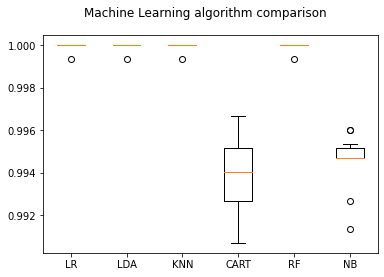

In [15]:

scoring    = "accuracy"
seed=9
num_trees=100
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))

# variables to hold the results and names
results = []
names   = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model,trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support as score

print("\n=====================LogisticRegression======================\n")
model1=LogisticRegression()
model1.fit(trainDataGlobal,trainLabelsGlobal)
y_pred1 = model1.predict(testDataGlobal)
print('accuracy = ',accuracy_score(testLabelsGlobal, y_pred1))

cnf_matrix1 = confusion_matrix(testLabelsGlobal, y_pred1)
print('Confusion matrix:')
print(cnf_matrix1)
# y_score = model1.decision_function(x_val)
precision, recall, fscore, support = score(testLabelsGlobal, y_pred1)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

#####
print("\n=====================LinearDiscriminantAnalysis======================\n")
model2=LinearDiscriminantAnalysis()
model2.fit(trainDataGlobal,trainLabelsGlobal)
y_pred2 = model2.predict(testDataGlobal)
print('accuracy = ',accuracy_score(testLabelsGlobal, y_pred2))

cnf_matrix2 = confusion_matrix(testLabelsGlobal, y_pred2)
print('Confusion matrix:')
print(cnf_matrix2)
# y_score = model1.decision_function(x_val)
precision, recall, fscore, support = score(testLabelsGlobal, y_pred2)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

print("\n=====================KNeighborsClassifier======================\n")

####
model3=KNeighborsClassifier(n_neighbors=5)
model3.fit(trainDataGlobal,trainLabelsGlobal)
y_pred3 = model3.predict(testDataGlobal)
print('accuracy = ',accuracy_score(testLabelsGlobal, y_pred3))

cnf_matrix3 = confusion_matrix(testLabelsGlobal, y_pred3)
print('Confusion matrix:')
print(cnf_matrix3)
# y_score = model1.decision_function(x_val)
precision, recall, fscore, support = score(testLabelsGlobal, y_pred3)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))


####
print("\n=====================DecisionTreeClassifier======================\n")

model4= DecisionTreeClassifier()
model4.fit(trainDataGlobal,trainLabelsGlobal)
y_pred4 = model4.predict(testDataGlobal)
print('accuracy = ',accuracy_score(testLabelsGlobal, y_pred4))

cnf_matrix4 = confusion_matrix(testLabelsGlobal, y_pred4)
print('Confusion matrix:')
print(cnf_matrix4)
# y_score = model1.decision_function(x_val)
precision, recall, fscore, support = score(testLabelsGlobal, y_pred4)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))


###
print("\n=====================RandomForestClassifier======================\n")

model5=RandomForestClassifier(n_estimators=100,random_state=0)
model5.fit(trainDataGlobal,trainLabelsGlobal)
y_pred5 = model5.predict(testDataGlobal)
print('accuracy = ',accuracy_score(testLabelsGlobal, y_pred5))

cnf_matrix5 = confusion_matrix(testLabelsGlobal, y_pred5)
print('Confusion matrix:')
print(cnf_matrix5)
# y_score = model1.decision_function(x_val)
precision, recall, fscore, support = score(testLabelsGlobal, y_pred5)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))


####
print("\n=====================GaussianNB======================\n")

model6=GaussianNB()
model6.fit(trainDataGlobal,trainLabelsGlobal)
y_pred6 = model6.predict(testDataGlobal)
print('accuracy = ',accuracy_score(testLabelsGlobal, y_pred6))

cnf_matrix6 = confusion_matrix(testLabelsGlobal, y_pred6)
print('Confusion matrix:')
print(cnf_matrix6)
# y_score = model1.decision_function(x_val)
precision, recall, fscore, support = score(testLabelsGlobal, y_pred6)

print('precision: {}'.format(precision))
print('recall   : {}'.format(recall))
print('fscore   : {}'.format(fscore))
print('support  : {}'.format(support))








=====================LogisticRegression======================

accuracy =  1.0
Confusion matrix:
[[940   0   0   0]
 [  0 940   0   0]
 [  0   0 954   0]
 [  0   0   0 926]]
precision: [1. 1. 1. 1.]
recall: [1. 1. 1. 1.]
fscore: [1. 1. 1. 1.]
support: [940 940 954 926]

=====================LinearDiscriminantAnalysis======================

accuracy =  1.0
Confusion matrix:
[[940   0   0   0]
 [  0 940   0   0]
 [  0   0 954   0]
 [  0   0   0 926]]
precision: [1. 1. 1. 1.]
recall: [1. 1. 1. 1.]
fscore: [1. 1. 1. 1.]
support: [940 940 954 926]

=====================KNeighborsClassifier======================

accuracy =  1.0
Confusion matrix:
[[940   0   0   0]
 [  0 940   0   0]
 [  0   0 954   0]
 [  0   0   0 926]]
precision: [1. 1. 1. 1.]
recall: [1. 1. 1. 1.]
fscore: [1. 1. 1. 1.]
support: [940 940 954 926]

=====================DecisionTreeClassifier======================

accuracy =  0.9936170212765958
Confusion matrix:
[[938   0   2   0]
 [  5 932   0   3]
 [  2   3 946   3]
 [ 

In [ ]:
from joblib import dump
dump(model2, 'weight2h.joblib') 
